In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')

In [2]:
from sys import path
path.append('..')
from convexcontrol.main import Controller
from convexcontrol.resources import PVSys, Battery, TCL

In [3]:
controller = Controller(mu=1e3)

In [4]:
controller.addResource(PVSys('pv1', T=201))
controller.addResource(Battery('batt1', Cb=1e-2))
controller.addResource(TCL('hvac1', Chvac=1e-1))

In [5]:
agg_point = np.zeros(200)
agg_point[:40] = np.linspace(-40, 40, 40)
agg_point[40:60] = np.linspace(40, 0, 20)
agg_point[100:125] = 20.
agg_point[125:130] = 25.
agg_point[130:135] = 30.
agg_point[135:140] = 35.
agg_point[140:145] = 30.
agg_point[145:150] = 25.
agg_point[150:175] = -25.
agg_point[175:200] = -50.

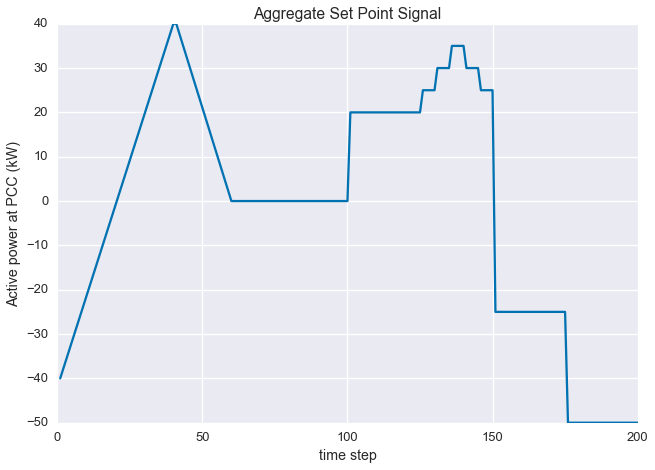

In [6]:
plt.plot(figsize=(14, 8))
plt.plot(range(1, 201), agg_point)
plt.xlabel('time step')
plt.ylabel('Active power at PCC (kW)')
plt.title('Aggregate Set Point Signal')

In [7]:
cols = ['PCC req', 'PCC imp', 'eps', 'batt SoC']
cols.extend([r + ' req' for r in controller.resource_names])
cols.extend([r + ' imp' for r in controller.resource_names])
cols

['PCC req',
 'PCC imp',
 'eps',
 'batt SoC',
 'pv1 req',
 'batt1 req',
 'hvac1 req',
 'pv1 imp',
 'batt1 imp',
 'hvac1 imp']

In [8]:
output = pd.DataFrame(columns=cols, index=range(len(agg_point)))
for t in range(len(agg_point)):
    # solve optimization for a single step
    p_star, eps_star, opt_val = controller.solveStep(agg_point[t], solver='MOSEK')
    output.loc[t]['PCC req'] = np.sum(p_star)
    output.loc[t]['eps'] = eps_star
    
    p_total = 0
    for i in range(controller.N):
        key1 = controller.resource_names[i] + ' req'
        key2 = controller.resource_names[i] + ' imp'
        output.loc[t][key1] = np.float(p_star[i][0][0])
        output.loc[t][key2] = np.float(controller.resource_list[i].projFeas(p_star[i,:])[0][0])
        p_total += output.loc[t][key2]

    output.loc[t]['PCC imp'] = p_total
    output.loc[t]['batt SoC'] = np.float(controller.resource_list[1].SoC)

In [9]:
output.head()

,PCC req,PCC imp,eps,batt SoC,pv1 req,batt1 req,hvac1 req,pv1 imp,batt1 imp,hvac1 imp
0,-40,-41.8376,-3.66021e-09,0.2,18.1624,-50,-8.1624,18.1624,-50,-10
1,-37.9487,-41.672,-3.23834e-08,0.22924,18.328,-50,-6.27673,18.328,-50,-10
2,-35.8974,-51.532,-3.68299e-08,0.25848,24.1026,-50,-10,8.46804,-50,-10
3,-33.8462,-33.8462,-5.31385e-08,0.287719,8.46804,-32.3142,-10,8.46804,-32.3142,-10
4,-31.7949,-31.7949,-3.88635e-08,0.306616,11.0737,-32.8686,-10,11.0737,-32.8686,-10


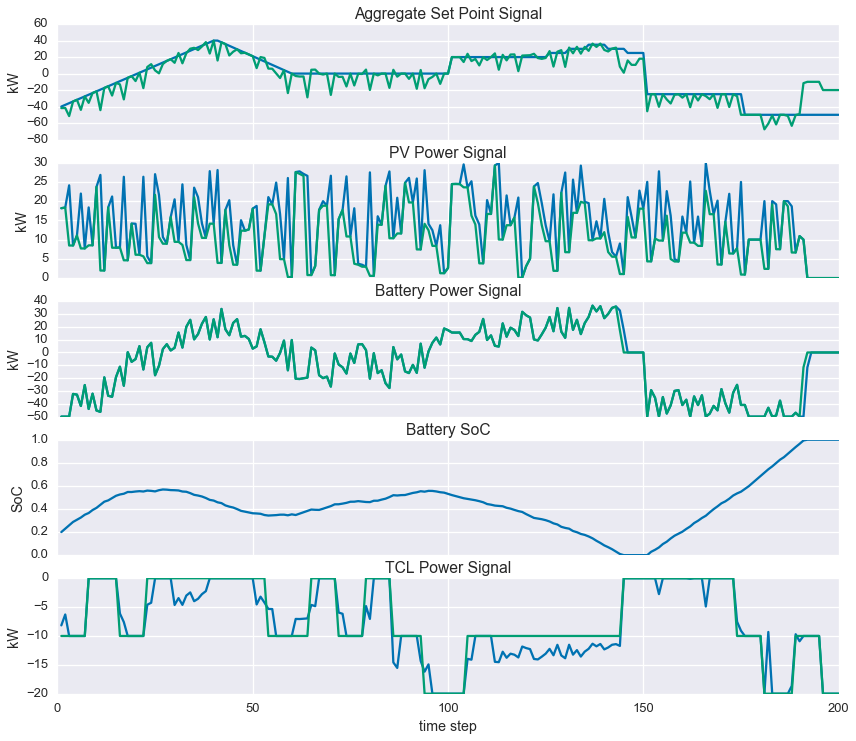

In [14]:
fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(14, 12))
ax[0].plot(range(1, 201), agg_point)
ax[0].plot(range(1, 201), output['PCC imp'])
ax[1].plot(range(1, 201), output['pv1 req'])
ax[1].plot(range(1, 201), output['pv1 imp'])
ax[2].plot(range(1, 201), output['batt1 req'])
ax[2].plot(range(1, 201), output['batt1 imp'])
ax[3].plot(range(1, 201), output['batt SoC'])
ax[4].plot(range(1, 201), output['hvac1 req'])
ax[4].plot(range(1, 201), output['hvac1 imp'])
ax[-1].set_xlabel('time step')
ax[0].set_ylabel('kW')
ax[1].set_ylabel('kW')
ax[2].set_ylabel('kW')
ax[3].set_ylabel('SoC')
ax[4].set_ylabel('kW')
ax[0].set_title('Aggregate Set Point Signal')
ax[1].set_title('PV Power Signal')
ax[2].set_title('Battery Power Signal')
ax[3].set_title('Battery SoC')
ax[4].set_title('TCL Power Signal')
plt.show()